# **Aerial Cactus Identification - 데이터 분석**

**학습 목표**  
항공 사진에서 선인장을 식별하는 대회로, 이 대회를 통해 데이터 처리 방법, 신경망 모델 설계 방법, 파이토치 기본 활용법을 배움  
딥러닝 모델을 다루는 방법 중심으로 학습함  
**학습 순서**  
대회 이해 -> 탐색적 데이터 분석 -> 베이스라인 모델(기본 CNN) -> 성능 개선(깊은 CNN)  
**키워드**  
유형 및 평가 지표 : 이진분류, ROC AUC  
데이터 준비 : 데이터셋, 데이터 로더, torchvision 모듈, 이미지 변환, 데이터 증강  
딥러닝 모델 : CNN, 합성곱, 풀링, 평탄화, 전결합, 배치 정규화, ReLU, Leaky ReLU  
훈련 : 교차 엔트로피 오차, 확률적 경사 하강법(SGD), 학습률, 에폭, Adamax

## **탐색적 데이터 분석**
데이터를 둘러보고, 타깃값 분포를 알아본 뒤, 이미지 몇 개를 샘플로 출력해보기  

### **데이터 둘러보기**

In [1]:
# cvs 데이터 불러오기
import pandas as pd
data_path = '/kaggle/input/aerial-cactus-identification/'
labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [2]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


**분석 결과**  
id는 이미지 파일명(확장자인 jpg 포함), has_cactus는 타깃값(0 : 선인장 없음, 1 : 선인장 있음)

In [3]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


**분석 결과**  
아직은 제출용 샘플이라 타깃값은 의미없음. 우리가 테스트 이미지 데이터에 선인장이 있을 확률을 예측해 타깃값 갱신해야 함.

### **데이터 시각화**

**Note**  
csv 파일에는 이미지 파일명과 타깃값만 존재할 뿐 이미지 자체의 특성이나 추가적인 메타 정보(날짜, 위치, 조건 등)는 없기 때문에 csv만으로는 모델링에 쓸 수 있는 정보가 거의 없음. csv 파일만으로 시각화해볼 수 있는 것은 타깃값의 분포뿐임. 그럼에도 시각화를 해보는 이유은 타깃값이 얼마나 불균형한지 알아보고 실제 이미지가 어떻게 생겼는지 살펴보기 위함.

**타깃값 분포**  
파이 그래프 사용

([<matplotlib.patches.Wedge at 0x7a13b6a51b50>,
 [Text(-0.7793519565739234, 0.7762799287527649, 'Has cactus'),
  Text(0.7793519929142085, -0.776279892268666, 'Has no cactus')],
 [Text(-0.42510106722213997, 0.42342541568332626, '75.1%'),
  Text(0.4251010870441137, -0.42342539578290866, '24.9%')])

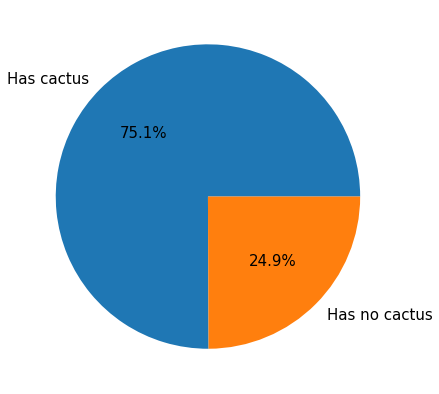

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15) # rc는 matplotlib의 설정값을 바꾸는 함수, 여기서는 글자 크기(font size)를 15로 키 (기본값보다 큼)
plt.figure(figsize=(7, 7))
label = ['Has cactus', 'Has no cactus'] # 타깃값 레이블, 파이차트에 보여줄 라벨(이름) 을 지정

# 타깃값 분포 파일 레이블
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%')
# (has_cactus 열의 값 개수, 위에서 만든 라벨 이름을 각각의 조각에 표시, 퍼센트를 표시(%.1f%%: 소수점 1자리까지))

**이미지 출력**  
직접 압축을 풀지 않고, 코드로 압축 파일 풀기 : zipfile 모듈의 ZipFile 클래스 사용

In [5]:
from zipfile import ZipFile

'''zip 파일 압축 풀기 :  # ZipFile() 파라미터로 zip 파일 경로 전달, with문으로 할당한 zipper 객체에 extracall() 메소드 호출'''

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()

# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

In [6]:
# os.listdir()을 호출하면 인수로 전달한 경로에 들어 있는 파일들의 이름 전체를 반환함 

import os

num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'훈련 데이터 개수: {num_train}')
print(f'테스트 데이터 개수: {num_test}')

훈련 데이터 개수: 17500
테스트 데이터 개수: 4000


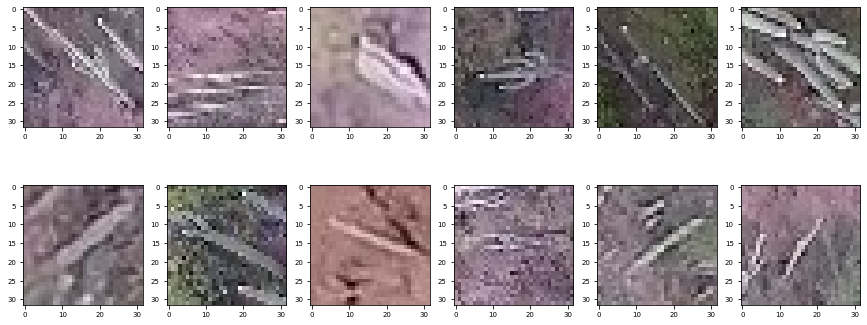

In [7]:
# 훈련 이미지 데이터 출력하기

import matplotlib.gridspec as gridspec
import cv2 # opencv 라이브러리 임포트

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6) # 서브 플롯 2x6

# 선인장을 포함하는 이미지 파일명 (마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 (cv2.imread()로 이미지를 읽으면 색상 채널을 BGR로 가져옴)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

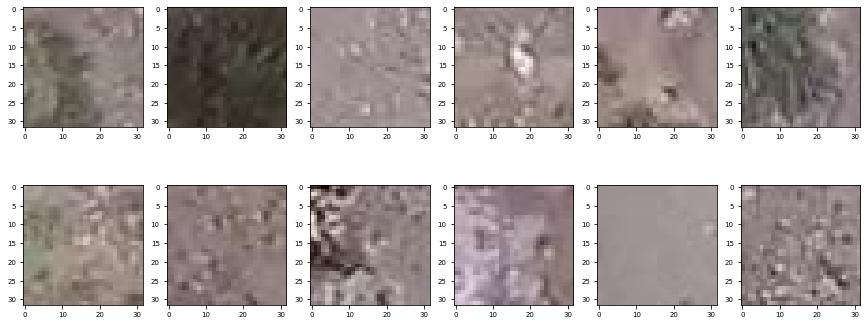

In [8]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하지 않는 이미지 파일명 (마지막 12개)
last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

In [9]:
image.shape

(32, 32, 3)

**분석 결과**  
가로, 세로 크기는 32x32이며 채널은 3개(RGB) 낮은 해상도의 컬러 이미지를 제공함

---
### **분석 정리 및 모델링 전략**
**분석 정리**  
cvs 파일의 id 피처는 이미지 파일명이므로 파일의 경로명만 추가하면 파일의 위치를 바로 얻어올 수 있음   
제공된 이미지들은 낮은 해상도의 컬러 이미지(32x32x3)임  
**모델링 전략**  
이번 대회에서는 딥러닝 모델(CNN)을 다루는 방법에 집중함 베이스라인에서는 얕은 CNN을 기본적인 설정만으로 만들어보면서 전체적인 흐름을 익히고 성능 개선에서는 더 깊은 CNN에 몇 가지 최적화 요소를 추가함  

베이스라인 모델 : 얕은 CNN
- 신경망 구조 : 합성곱 x 2, 풀링, 평탄화, 전결합
- 옵티마이저 : SGC

성능 개선 : 살짝 깊은 CNN
- 데이터 증강 : 다양한 변환기 사용
- 신경망 구조 : 합성곱 x 5, 배치 정규화, 평탄화, 전결합 x 2
- 옵티마이저 : Adamax
- 기타 : 훈련 에폭 수 증가
---

# **Aerial Cactus Identification - 베이스라인 모델**
파이토치를 활용해 딥러닝 모델 만들기, 베이스라인은 간단한 CNN 모델을 활용함  
**파이토치**  
딥러닝 모델을 쉽게 만들고 학습시킬 수 있도록 도와주는 도구(프레임워크)

**파이토치를 활용한 딥러닝 모델링 절차**  
**1. 시드값 고정 및 GPU 장비 설정**
- 시드값 고정 : 결과 재현을 위한 작업, 모델 학습 결과가 실행할 때마다 달라지지 않게 랜덤값을 고정하는 작업
- GPU 장비 설정 : 훈련 속도를 높이기 위해 데이터를 연산 속도가 빠른 GPU가 처리하도록 변경, 딥러닝은 데이터도 크고 행렬 연산이 엄청 많기 때문에 병렬 연산에 최적화 된 GPU를 쓰면 학습 속도를 높일 수 있음 

**2. 데이터 준비**
- 훈련/검증 데이터 분리
- 데이터셋 클래스 정의 : 이미지 데이터를 모델링에 적합한 형태로 불러오도록 해줌, 이미지 데이터를 모델이 이해할 수 있는 형식으로 바꿔주는 코드 블록
- 데이터셋 생성
- 데이터 로더(데이터셋으로부터 데이터를 배치 단위로 불러와주는 객체) 생성 : 데이터를 미니배치 단위로 나눠서 모델에 조금씩 공급해주며 학습 효율을 향상시킴, 미니배치는 전체 데이터셋이 너무 크니까 작게 잘라서 나눠서 학습하는 방식(속도 빨라짐, 일반화 능력 향상, 안정적인 학습 가능)
  
**3. 모델 생성** : 신경망 모델 클래스를 직접 설계한 후 인스턴스 생성  
- CNN 구조로 신경망을 직접 만드는 과정
- CNN? 딥러닝에서 이미지 처리에 가장 많이 쓰이는 모델 과정, 이미지 안의 모양이나 패턴(엣지, 윤곽, 질감 등)을 자동으로 잘 찾아내기 때문에 많이 쓰임
  
**4. 모델 훈련**
- 손실 함수와 옵티마이저 설정 : 훈련에 앞서 손실 함수(예측값과 실젯값의 차이를 구하는 함수)와 옵티마이저(최적 가중치를 찾아주는 알고리즘) 설정
- 모델 훈련 : 신경망의 가중치(파라미터)를 갱신하며 모델 훈련
  
**5. 성능 검증** : 검증 데이터로 모델 성능 검증
  
**4. 모델 훈련** : 테스트 데이터로 예측 후 결과 제출

### **시드값 고정 및 GPU 장비 설정**

**시드값 고정**  
시드값을 고정하는 이유는 다시 실행해도 같은 결과를 얻기 위해서임. 파이토치로 딥러닝 모델링을 할 때는 모델 훈련 시가 아닌 맨 처음에 고정함.  
아래의 쓰여진 모든 시드값 코정 코드가 캐글에서 GPU로 파이토치 사용 시 반드시 필요한 건 아님. 그러나 교재와는 다른 환경에서 작업할 수도 있으므로 최대한 많은 시드값을 고정한 거임.  
또한 파이토치는 시드값을 고정하더라도 해시값들에 따라서 결과가 달라질 수 있음. 즉, 시드값을 고정하더라도 결과가 완벽히 같다는 보장이 없음.  
반대로 결과를 재현할 피룡가 없다면 시드값 고정은 생략하는 게 나을 수 있음. 파이토치를 사용할 때 시드값을 고정하면 속도도 느려지고 예측 성능도 떨어질 우려가 있기 때문임.

In [10]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 GPU 사용 시)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

**GPU 장비 설정**  
딥러닝 경진대회는 주로 비정형 데이터(이미지, 음성, 텍스트 등)를 다루며 이러한 비정형 데이터는 모델링하려면 연산량이 많아짐. 따라서 CPU로 감당하기 벅찰 정도로 훈련 시간이 너무 길어져 GPU를 사용함. GPU는 단순 연산 수백~수만 개 이상을 병렬로 처리할 수 있어서 딥러닝 모델을 CPU보다 훨씬 빠르게 훈련시켜줌.

In [11]:
# 연산에 이용할 장비 할당
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device =torch.device('cpu')

In [12]:
device

device(type='cuda')

### **데이터 준비**
- 훈련/검증 데이터 분리
- 데이터셋 클래스 정의
- 데이터셋 생성
- 데이터 로더 생성

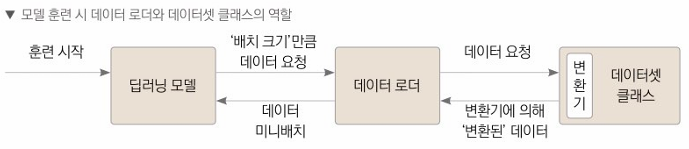  
결국은 딥러닝 모델의 훈련에 필요한 데이터를 미니배치 단위로 공급하는 역할을 함. 이때 데이터셋 클래스에 정의된 변환기가 원본 데이터를 다양한 형태로 변환해줌.

**훈련 데이터, 검증 데이터 분리**  
현재 labels에는 대회 주최 측에서 제공한 train.csv 파일의 내용이 담겨 있음. train_test_split() 함수를 사용해 이 데이터를 훈련 데이터와 검증 데이터로 나눔.

In [13]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels,
                               test_size=0.1, # 검증 데이터의 비율
                               stratify=labels['has_cactus'], # 타깃값 비율은 약 3:1
                               random_state=50)

In [14]:
print('훈련 데이터 개수: ', len(train))
print(f'검증 데이터 개수: {len(valid)}')

훈련 데이터 개수:  15750
검증 데이터 개수: 1750


**데이터셋 클래스 정의**  
사용자 정의 데이터셋을 만듦. 파이토치로 신경망 모델을 구축하려면 데이터셋도 일정한 형식에 맞게 정의해줘야 함.

In [15]:
# 데이터셋 생성에 필요한 라이브러리 임포트
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

파이토치에서 제공하는 Dataset 클래스를 활용해 데이터셋 객체를 만들 수 있음. Dataset은 추상 클래스이며, 우리는 Dataset을 상속받은 특수 메소드인 __len__()과 __getitem__()을 오버라이딩해야 함.  
- __len__() : 데이터셋 크기 반환
- __getitem__() : 인덱스를 전달받아 인덱스에 해당하는 데이터를 반환함

추상 클래스 : 곧바로 객체를 생성할 수 없고 상속만 할 수 있는 클래스로, 상속받는 클래스의 메소드를 규격화하기 위해 사용함

In [19]:
class ImageDataset(Dataset):
    # 초기화 메소드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    # 데이터셋 크기 반환 메소드
    def __len__(self):
        return len(self.df)
    # 인덱스에 해당하는 데이터 반환 메소드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로
        image = cv2.imread(img_path)     # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)
        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

파라미터 역할  
- df : DataFrame의 객체, train or valid를 df 파라미터에 전달
- img_dir : 이미지 데이터를 포함하는 경로
- transform : 이미지 변환기, 이미지 데이터셋을 만들 때 기본적인 전처리를 할 수 있으며 전처리를 하려면 이미지 변환기를 넘겨주면 됨

함수
- __len() : 데이터셋의 크기를 반환하는 메소드
- __getitem() : idx번째 이미지와 레이블을 반환함, 초기화 메소드에서 받은 경로에 이미지 ID를 합쳐 이미지 위치를 알아내고 초기화 메소드에서 이미지 변환기를 받아뒀다면 변환 작업까지 수행한 후 반환함

**데이터셋 생성**

In [17]:
from torchvision import transforms # 이미지 변환을 위한 모듈
transform = transforms.ToTensor()

torchvision은 파이토치용 컴퓨터 비전 라이브러리며, transforms는 다양한 이미지 변환기를 제공하는 모듈임.  
ToTensor() 메소드로 이미지를 텐서로 바꿈. 이때 (가로 픽셀 수, 세로 픽셀 수, 채널 수) 형상이 (채널 수, 가로 픽셀 수, 세로 픽셀 수) 형상으로 바뀜(파이토치로 이미지를 처리할 때는 이 형상 순이어야 하기 때문). 여기에 배치가 추가된다면 (배치 크기, 채널 수, 가로 픽셀 수, 세로 픽셀 수) 형상이 됨.  
보통은 여러 가지 변환을 적용하기 위해 변환기 몇 개를 결합해 사용하지만 여기서는 간단하게 텐서로 바꾸는 변환기만 만듦.  

**텐서**  
모든 원소의 데이터 타입이 같은 다차원 배열

In [20]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform)

**데이터 로더 생성**  
데이터 로더는 지정한 배치 크기만큼씩 데이터를 불러오는 객체임. 딥러닝 모델을 훈련할 때는 묶음 단위로 훈련하는 게 훨씬 빠르기 때문에 주로 배치 단위로 데이터를 가져와 훈련함.

In [22]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True) # 특정 데이터가 몰려있을 경우에 대비해 훈련 데이터에서는 shuffle = True로 전달
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

**Note**  
배치 크기는 4에서 256까지 다양하게 설정할 수 있음(흔하지 않지만 4보다 작거나 256보다 큰 값도 가능함). 배치 크기가 작으면 규제 효과가 있어 일반화 성능이 좋아지지만, 한 번에 불러오는 데이터가 적어 훈련 이터레이션이 많아지고 훈련 시간도 길어짐. 게다가 배치 크기가 작을 수록 학습률도 작게 설정해야 하는데, 이는 훈련 시간을 지연시키는 또 다른 원인이 됨. 배치 크기는 2의 제곱수로 설정하는 게 효율적이지만 배치 크기에 정답은 없음. 다양하게 시도해보아야 함.

### **모델 생성**
기본적인 합성곱 신경망(CNN) 모델 생성함. (3, 32, 32) 형상의 이미지 데이터를 두 번의 합성곱과 풀링, 평탄화, 전결합 등을 거쳐 최종적으로 값이 0일 확률과 1일 확률을 구함.
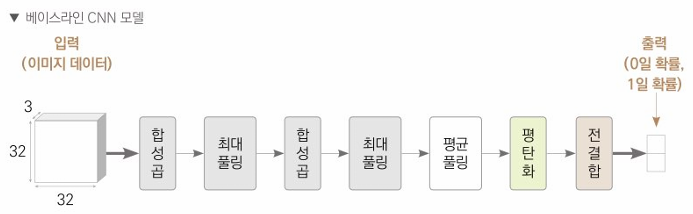

In [23]:
# CNN 모듈을 만드는 데 필요한 두 모듈을 불러옴
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

In [29]:
class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메소드 호출
        # 첫 번째 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        # 두 번째 합성곱 계층
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        # 최대 풀링 계층
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        # 전결합 계층
        self.fc = nn.Linear(in_features=64*4*4, out_features=2)

    # 순전파 출력 정의
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        return x

model = Model().to(device)

In [25]:
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (gc): Linear(in_features=1024, out_features=2, bias=True)
)

### **모델 훈련**  
모델 훈련에 앞서 손실 함수와 옵티마이저 정의

**손실 함수 설정**  
신경망 모델 훈련은 가중치를 갱신하는 작업인데, 가중치 갱신은 예측값과 실젯값의 손실이 작아지는 방향으로 이루어짐. 이때 손실값을 구하는 함수가 손실 함수이며 여기서 손실 함수로 교차 엔트로피를 사용함  
**교차 엔트로피** : 딥러닝 분류 모델에서 자주 사용하는 손실 함수 
  
**Note**  
어떤 손실 함수를 쓸지 판단을 어떻게 할까? nn.CrossEntropyLoss()를 자주 사용하긴 하지만 상황에 따라 다른 함수를 사용할 수도 있음. 처음부터 이론적 배경이나 수식을 모두 이해하고 적용하는 것은 쉽지 않으므로 가장 좋은 방법은 다른 캐글러가 공유한 코드를 참고하는 것임. 다른 캐글러는 주로 어떤 손실 함수를 썼는지 살펴보고, 필요하다면 이론이나 수식을 찾아보면 됨.

In [26]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

**옵티마이저 설정**  
옵티마이저는 최적 가중치를 찾아주는 알고리즘임. 베이스라인이므로 기본 옵티마이저인 SGD로 설정함. SGD는 경사 하강법을 이용한 옵티마이저임.

In [27]:
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # lr : 학습률

**모델 훈련 절차**  
1. 데이터 로더에서 배치 크기만큼 데이터를 불러옴
2. 불러온 이미지 데이터와 레이블(타깃값) 데이터를 장비(GPU or CPU)에 할당함
3. 옵티마이저 내 기울기를 초기화 함
4. 신경망 모델에 입력 데이터(이미지)를 전달해 순전파하여 출력값(예측값)을 구함
5. 예측값과 실제 레이블(타깃값)을 비교해 손실을 계산함
6. 손실을 기반으로 역전파를 수행함
7. 역전파로 구한 기울기를 활용해 가중치를 계산함
8. 1~7 절차를 반복 횟수만큼 되풀이 함
9. 1~8 절차를 에폭만큼 반복함

**에폭 vs. 배치 크기 vs. 반복 횟수**  
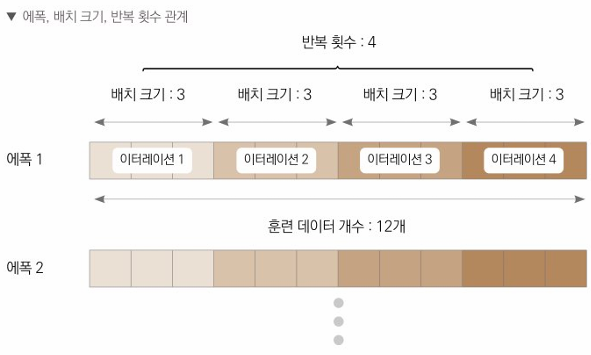  
**에폭** : 훈련 데이터 전체를 한 번 훑었음을 뜻함. 신경망 가중치가 최적화되기에는 1에폭만 훈련해서는 부족하므로 보통 수십~수백 에폭만큼 훈련함. 즉, 훈련 데이터 전체를 여러 차례 반복 훈련하는 것. 에폭이 너무 적으면 과소적합, 너무 많으면 과대적합이 발생함.  
**배치 크기** : 매 훈련 이터레이션에서 한 번에 훈련할 데이터 개수임. 만약 배치 크기를 32로 설정하면, 훈련 데이터 32개를 한 묶음으로 보고 가중치를 함께 갱신하겠다는 뜻임.  
**반복 횟수** : 1에폭의 훈련을 완료하는 데 필요한 훈련 이터레이션을 일컥음. 간단하게 훈련 데이터 개수를 배치 크기로 나누면 됨(소수점은 올림 처리). 본 경진대회의 훈련 데이터는 15,750개고, 배치 크기는 32로 설정했으므로 반복 횟수는 15,750 / 32를 올림한 493번임.

In [31]:
epochs = 10 # 총 에폭
# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화

    # 반복 횟수만큼 반복
    for images, labels in loader_train: #데이터 로더는 하나의 배치를 한 묶음으로 처리하므로 데이터 로더를 반복 횟수라고 생각해도 됨
        # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()

    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/10] - 손실값: 0.6736
에폭 [2/10] - 손실값: 0.6735
에폭 [3/10] - 손실값: 0.6736
에폭 [4/10] - 손실값: 0.6735
에폭 [5/10] - 손실값: 0.6735
에폭 [6/10] - 손실값: 0.6735
에폭 [7/10] - 손실값: 0.6736
에폭 [8/10] - 손실값: 0.6735
에폭 [9/10] - 손실값: 0.6735
에폭 [10/10] - 손실값: 0.6735


### **성능 검증**
검증 데이터를 이용해 평가지표인 ROC AUC 값을 구함

In [32]:
'''먼저 사이킷런에서 제공하는 ROC QUC 계산 함수를 임포트하고 실젯값과 예측 확률을 담을 리스트를 초기화 함'''
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트
# 실젯값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

In [33]:
# 검증 데이터로 모델 성능 평가하기
model.eval() # 모델을 평가 상태로 설정

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률
        true = labels.cpu() # 실젯값
        # 예측 확률과 실젯값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)

# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 ROC AUC : 0.6114


### **예측 및 결과 제출**

In [34]:
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

**예측**  
테스트 데이터에서 타깃값이 1일 확률을 예측해보기

In [35]:
model.eval() # 모델을 평가 상태로 설정
preds = []   # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)

        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [36]:
torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()

[0.5142402648925781,
 0.5151678919792175,
 0.5192246437072754,
 0.5171909928321838,
 0.517521858215332,
 0.5179754495620728,
 0.5219498872756958,
 0.5210012793540955,
 0.5178267359733582,
 0.521808385848999,
 0.5170241594314575,
 0.5212777853012085,
 0.522376298904419,
 0.5207964777946472,
 0.5227739214897156,
 0.5178426504135132,
 0.5182497501373291,
 0.5194264650344849,
 0.5198837518692017,
 0.5188032388687134,
 0.5188910961151123,
 0.5181803703308105,
 0.5181103348731995,
 0.5237118005752563,
 0.5158929824829102,
 0.5195878744125366,
 0.5200619697570801,
 0.5210930705070496,
 0.5227029323577881,
 0.5197877883911133,
 0.5181375741958618,
 0.5189945101737976]

In [39]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)

In [40]:
# 제출 전 훈련 이미지 데이터와 테스트 이미지 데이터를 모두 삭제
import shutil

shutil.rmtree('./train') # rmtree() : 전달받은 디렉토리 전체 삭제 메소드
shutil.rmtree('./test')